Running the WMMSE algorithm for the following setup:

- MIMO interference channel
- Noise powers and weights are set equally for all users
- P = 10^(SNR/10); SNR = 25 dB
- 4 cells
- n_tx = all 3
- n_rx = all 2
- Channel coefficients generated from CN(0, 1)


In [1]:
import os
import sys
import json
import torch
import importlib
import matplotlib.pyplot as plt
# Get the current working directory
scripts_dir = os.getcwd()
# Go up one level
project_root = os.path.abspath(os.path.join(scripts_dir, '..'))
sys.path.append(project_root)

import src.WMMSE
importlib.reload(src.WMMSE)
from src.WMMSE import WMMSE_alg

import src.utils
importlib.reload(src.utils)
from src.utils import calculate_sum_rate

In [2]:
SNR = 15
P = 10**(SNR/10)
K = 4  # number of cells
I_k = [1, 1, 1, 1]  # number of users in each cell
n_tx = [3, 3, 3, 3]  # number of antennas at each transmitter
n_rx = [[2], [2], [2], [2]]  # number of antennas at each user in each cell
P_k = [P, P, P, P]
sig_i_k = [[.1], [.1], [.1], [.1]]
d = [[2], [2], [2], [2]]
alpha = [[1], [1], [1], [1]]

# Initialize channel dictionary
H = {}
for k in range(K):  # transmitter cell index
    H[k] = {}
    for l in range(K):  # receiver cell index
        for i in range(I_k[l]):  # user index in cell l
            tx_ant = n_tx[k]
            rx_ant = n_rx[l][i]
            # Channel from transmitter k to user (l, i)
            H[k][(l, i)] = torch.randn(rx_ant, tx_ant, dtype=torch.cdouble)/(2**.5) + 1j*torch.randn(rx_ant, tx_ant, dtype=torch.cdouble)/(2**.5)

max_iter_mu = 1000
tol_mu = 1e-5
max_iter_alg = 100
tol_alg = 1e-4

wmmse = WMMSE_alg(K, I_k, n_tx, n_rx, H, P_k, sig_i_k, d, alpha, max_iter_mu, tol_mu, max_iter_alg, tol_alg)

In [4]:
# Initialize V
V = {}
for k in range(K):
    V[k] = {}
    for i in range(I_k[k]):
        V[k][i] = torch.rand(n_tx[k], d[k][i], dtype=torch.cdouble)
    ss = 0
    for i in range(I_k[k]):
        ss += torch.trace(V[k][i] @ V[k][i].conj().T)
    for i in range(I_k[k]):
        V[k][i] = V[k][i] * ((P_k[k])/ss)**0.5
        
V_l, U_l, W_l = wmmse.algorithm(V)

/Users/Ali/miniconda3/envs/Deep-Unfolding-NN/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/Ali/miniconda3/envs/Deep-Unfolding-NN/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'sum rate')

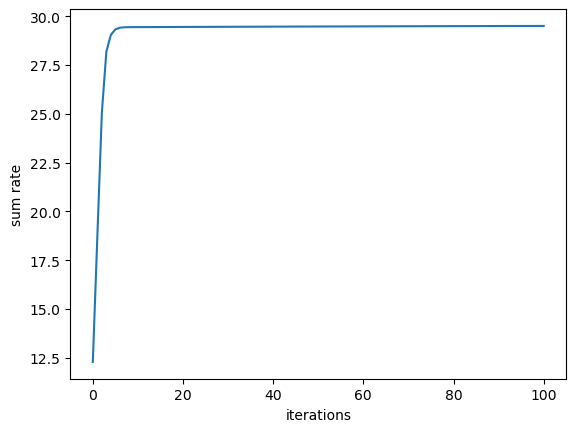

In [5]:
rr = []
for i in V_l:
    rr.append(calculate_sum_rate(H, I_k, i, alpha, sig_i_k))
plt.plot(rr)
plt.xlabel('iterations')  # Label for the x-axis
plt.ylabel('sum rate')